In [1]:
import pandas as pd
import numpy as np

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

import matplotlib.pyplot as plt
import seaborn as sns

from pandas import DataFrame
from pandas import Series

import warnings
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read in data
local_file="DataPrep/title.ratings.genresS.actorsG.csv"
source=local_file
df = pd.read_csv(source, sep='\t')
df.drop(df.columns[0], inplace=True, axis=1)

df["runtimeMinutes"]=df.runtimeMinutes.apply(int)
df["numVotes"]=df.numVotes.apply(int)

In [2]:
# df.head()
# df.dtypes
# list(df)

In [1]:
# df.genre.unique()

In [3]:
def modStats(model):
    modParams=model.params
    modAOVTable = sm.stats.anova_lm(model, typ=2)
    modSummary=model.summary()
    return(modParams, modAOVTable, modSummary)

In [4]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

#### ANOVA: ratings ~ genre

In [5]:
mod = smf.ols(formula='averageRating ~ genre', data=df).fit()
modParams, modAOVTable, modSummary=modStats(mod)
eta_squared(modAOVTable)
omega_squared(modAOVTable)
print(modAOVTable)

                 sum_sq        df            F  PR(>F)    eta_sq  omega_sq
genre      68847.056066      27.0  1756.723854     0.0  0.134934  0.134857
Residual  441380.466435  304085.0          NaN     NaN       NaN       NaN


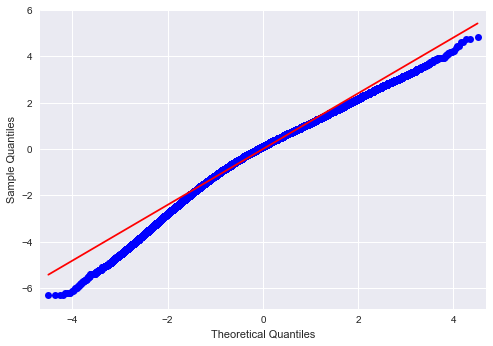

In [6]:
res = mod.resid
fig = sm.qqplot(res, line='s')
plt.show()

#### Determine which genre ratings differ significantly

In [26]:
test = multi.MultiComparison(df['averageRating'], df['genre'])
res = test.tukeyhsd()
d2 = pd.DataFrame(data=res._results_table.data[1:], columns=res._results_table.data[0])
#d2.sort_values(['meandiff'], ascending=0)
print(d2.nlargest(5, 'meandiff'))
print(d2.nsmallest(5, 'meandiff'))

     group1      group2  meandiff   lower   upper  reject
290  Horror        News    2.2303  2.0390  2.4215    True
291  Horror  Reality-TV    1.7283  0.7733  2.6833    True
296  Horror   Talk-Show    1.7065 -0.2953  3.7083   False
287  Horror       Music    1.6927  1.6138  1.7716    True
17   Action        News    1.5819  1.3919  1.7719    True
          group1  group2  meandiff   lower   upper  reject
174  Documentary  Horror   -2.1627 -2.2122 -2.1133    True
335         News  Sci-Fi   -2.0299 -2.2280 -1.8319    True
181  Documentary  Sci-Fi   -1.9624 -2.0339 -1.8910    True
111    Biography  Horror   -1.9351 -2.0072 -1.8631    True
273      History  Horror   -1.7937 -1.8690 -1.7184    True


#### Visualize genre rating differences

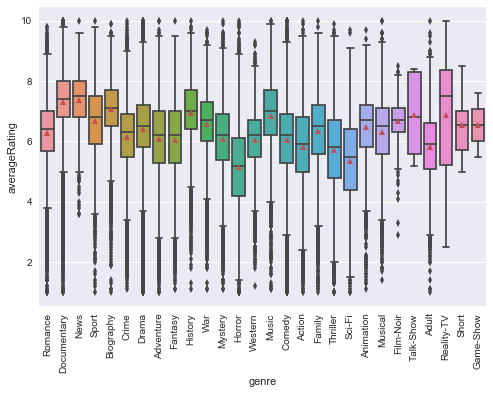

In [28]:
sns.boxplot(x=df['genre'], y=df['averageRating'], showmeans=True)
plt.xticks(rotation=90)
plt.show()

#### ANOVA: ratings ~ genre and # of votes

In [44]:
mod2 = smf.ols('averageRating ~ genre + numVotes + genre:numVotes', data=df).fit()
mod2Params, mod2AOVTable, mod2Summary=modStats(mod2)
eta_squared(mod2AOVTable)
omega_squared(mod2AOVTable)
print(mod2AOVTable)

                       sum_sq        df            F        PR(>F)    eta_sq  \
genre            70786.963211      27.0  1834.051316  0.000000e+00  0.138211   
numVotes          6215.538080       1.0  4348.111750  0.000000e+00  0.012136   
genre:numVotes     521.577315      27.0    13.513782  7.441319e-61  0.001018   
Residual        434643.351042  304057.0          NaN           NaN       NaN   

                omega_sq  
genre           0.138135  
numVotes        0.012133  
genre:numVotes  0.000943  
Residual             NaN  


#### ANOVA: ratings ~ genre and runtime minutes

In [45]:
mod3 = smf.ols('averageRating ~ genre + runtimeMinutes + genre:runtimeMinutes', data=genre_df).fit()
mod3Params, mod3AOVTable, mod3Summary=modStats(mod3)
eta_squared(mod3AOVTable)
omega_squared(mod3AOVTable)
print(mod3AOVTable)

                             sum_sq        df            F         PR(>F)  \
genre                  69423.612679      27.0  1793.637895   0.000000e+00   
runtimeMinutes          1423.375617       1.0   992.912200  1.402445e-217   
genre:runtimeMinutes    4080.363859      27.0   105.420835   0.000000e+00   
Residual              435876.726959  304057.0          NaN            NaN   

                        eta_sq  omega_sq  
genre                 0.135910  0.135834  
runtimeMinutes        0.002787  0.002784  
genre:runtimeMinutes  0.007988  0.007912  
Residual                   NaN       NaN  


#### Summary

Genre is correlated with ratings and explains 14% of variance<br>
When coupled with runtime minutes or number of variance, no additional significant variance is explained.